# **Feature Extraction - Mido/Pretty Midi**

In [18]:
pip install pretty-midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=078a3859d161b2bde7d0a0cce0250a91e1ee1367a7ba5d6afb5aeb6901e3b99a
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [1]:
pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 572.2 kB/s eta 0:00:00


In [35]:
# Load libraries
import os
import shutil
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import mido
import kagglehub
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Download the dataset off Kaggle
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
zip_path = os.path.join(path, 'midiclassics.zip')
extract_path = os.path.join('data', 'kaggle', 'midiclassics')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted files to:", extract_path)

100%|██████████| 68.2M/68.2M [00:03<00:00, 23.0MB/s]

Extracting files...


Extracted files to: data/kaggle/midiclassics


In [6]:
# Clean dataset
# Use a portion of Antonio's code as a baseline to set ourselves up the same
# Target composers
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Keep directories that contain a target composer's name
for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if not any(composer.lower() in item.lower() for composer in TARGET_COMPOSERS):
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Deleted directory: {item_path}")

# also delete "C.P.E.Bach" files. This was the son of J.S. Bach, and we want to keep only the main composers
for item in os.listdir(extract_path):
    if 'C.P.E.Bach' in item:
        item_path = os.path.join(extract_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Deleted directory: {item_path}")

Deleted file: data/kaggle/midiclassics/Bartok Suite 2mov.mid
Deleted file: data/kaggle/midiclassics/Tchaikovsky Lake Of The Swans Act 1 4mov.mid
Deleted directory: data/kaggle/midiclassics/Komzak
Deleted file: data/kaggle/midiclassics/Tchaikovsky Lake Of The Swans Act 1 6mov.mid
Deleted file: data/kaggle/midiclassics/Kuhlau Sonatina op55 n3 1mov.mid
Deleted directory: data/kaggle/midiclassics/Kuhlau
Deleted file: data/kaggle/midiclassics/Nicolai Overture The Merry Wives of Windsor.mid
Deleted directory: data/kaggle/midiclassics/Hummel
Deleted directory: data/kaggle/midiclassics/Alkan
Deleted file: data/kaggle/midiclassics/Debussy Suite Bergamasque 4mov.mid
Deleted directory: data/kaggle/midiclassics/Jakobowski
Deleted file: data/kaggle/midiclassics/Tchaikovsky Lake Of The Swans Act 2 13mov.mid
Deleted directory: data/kaggle/midiclassics/Albe'niz
Deleted file: data/kaggle/midiclassics/Sibelius Kuolema Vals op44.mid
Deleted directory: data/kaggle/midiclassics/Paradisi
Deleted directory: 

# Mido Feature Extraction - Notes, Velocity, Time

In [31]:
def extract_note_features_from_midi(midi_path, max_events=1000):
    try:
        midi_file = mido.MidiFile(midi_path)
        note_events = []
        # Loop through midi files
        for event in midi_file:
            if event.type == 'note_on' and event.velocity > 0:
                # Extract note pitch, velocity, and time
                note_events.append((event.note, event.velocity, event.time))
            if len(note_events) >= max_events:
                break
        if not note_events:
            return None
        # Convert list to numpy array
        note_matrix = np.array(note_events)
        # Pad with zeros
        if note_matrix.shape[0] < max_events:
            padding = max_events - note_matrix.shape[0]
            note_matrix = np.pad(note_matrix, ((0, padding), (0, 0)), mode='constant')
        else:
            note_matrix = note_matrix[:max_events]
        # Flatten - 1D feature vector
        return note_matrix.flatten()
    except Exception as error:
        print(f"Skip {midi_path}: {error}")
        return None

# PrettyMIDI Feature Extraction - Chords & Tempo

In [32]:
def extract_chords_tempo_from_midi(midi_path):
    try:
        midi_obj = pretty_midi.PrettyMIDI(midi_path)

        # Extract tempo changes & calculate avg tempo (BPM)
        tempo = midi_obj.get_tempo_changes()[1]
        avg_tempo = np.mean(tempo) if len(tempo) > 0 else 0.0

        # Extract chroma feature
        chroma = midi_obj.get_chroma()
        chord = np.mean(chroma, axis=1)

        return chord, avg_tempo
    except Exception as error:
        print(f"Tempo and/or Chord extraction failed {midi_path}: {error}")
        return None, None

In [33]:
# Initialize empty lists to store each feature
note_features = []
chord_features = []
tempo_features = []
composer_labels = []

# Loop through each composer
for composer_name in TARGET_COMPOSERS:
    composer_folder = os.path.join(extract_path, composer_name)
    if not os.path.isdir(composer_folder):
        continue
    for fname in os.listdir(composer_folder):
        if fname.endswith(".mid") or fname.endswith(".midi"):
            full_path = os.path.join(composer_folder, fname)
            # Extract note features - mido
            notes_f = extract_note_features_from_midi(full_path)
            # Extract tempo and chrod features - prettymidi
            chords_f, tempo_f = extract_chords_tempo_from_midi(full_path)

            if notes_f is not None and chords_f is not None and tempo_f is not None:
                note_features.append(notes_f)
                chord_features.append(chords_f)
                tempo_features.append([tempo_f])
                composer_labels.append(composer_name)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skip data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Tempo and/or Chord extraction failed data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


In [34]:
# Single feature matrix - stack notes, chord, and tempo features
X_full = np.hstack([
    np.array(note_features),
    np.array(chord_features),
    np.array(tempo_features)
])

# Convert the composer name to numerical labels using LabelEncoder
le = LabelEncoder()
y_full = le.fit_transform(composer_labels)

# Convert feature matrix and labels into PyTorch tensors
X_tensor = torch.tensor(X_full, dtype=torch.float32)
y_tensor = torch.tensor(y_full, dtype=torch.long)

# Create PyTorch dataset and loader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Total processed samples: {len(dataset)}")
print(f"Composer classes: {le.classes_}")

Total processed samples: 480
Composer classes: ['Bach' 'Beethoven' 'Chopin' 'Mozart']


# Tempo Distribution

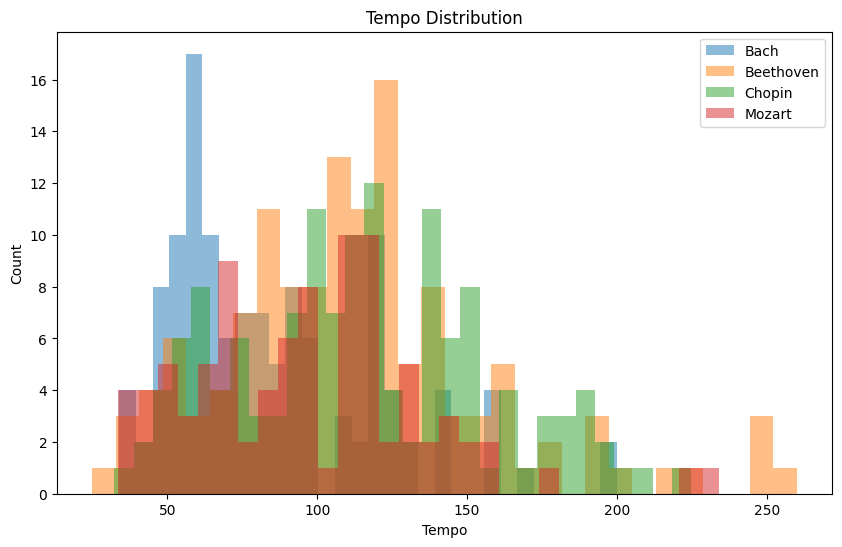

In [37]:
tempos = np.array(tempo_features).flatten()
labels = np.array(composer_labels)

plt.figure(figsize=(10,6))
for composer in np.unique(labels):
    composer_tempo = tempos[labels == composer]
    plt.hist(composer_tempo, bins=30, alpha=0.5, label=composer)

plt.title("Tempo Distribution")
plt.xlabel("Tempo")
plt.ylabel("Count")
plt.legend()
plt.show()

# Pitch Distribution

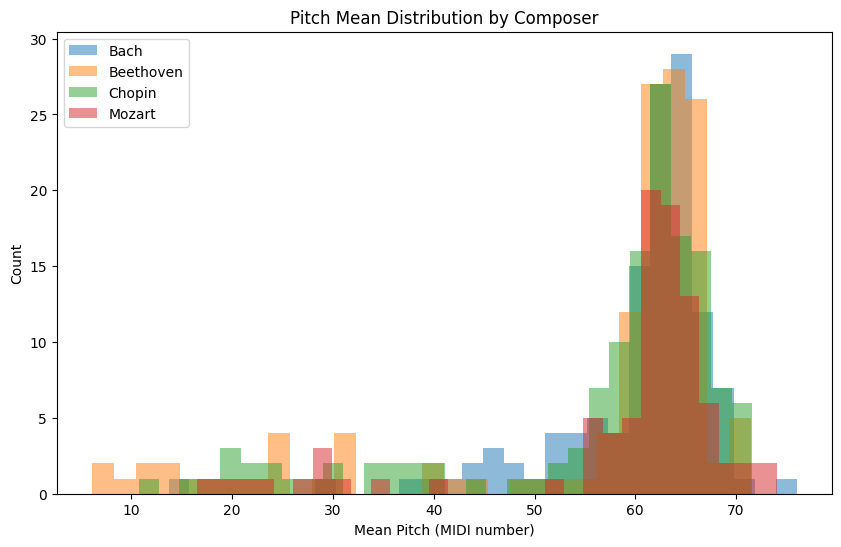

In [46]:
pitch_vals = pitch_mean
labels = np.array(composer_labels)

plt.figure(figsize=(10, 6))
for composer in np.unique(labels):
    comp_pitch = pitch_vals[labels == composer]
    plt.hist(comp_pitch, bins=30, alpha=0.5, label=composer)

plt.title("Pitch Mean Distribution by Composer")
plt.xlabel("Mean Pitch (MIDI number)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Velocity Distribution

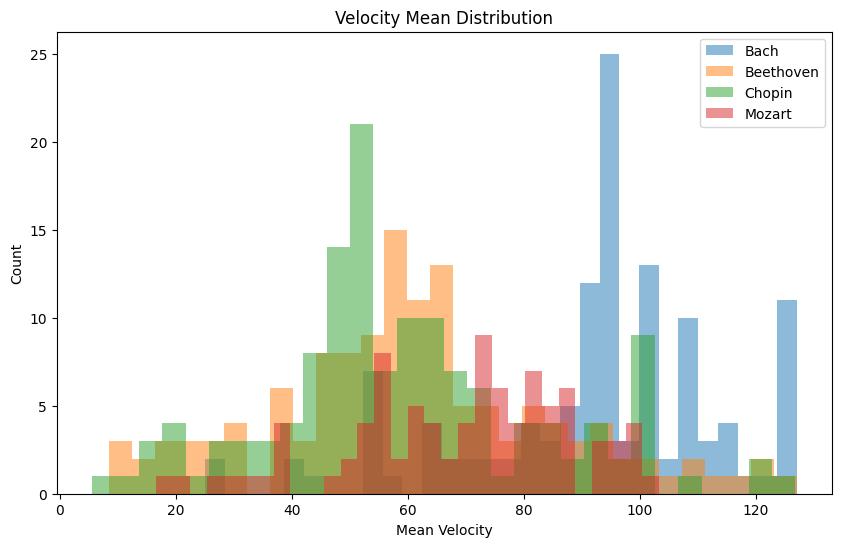

In [47]:
velocity_vals = velocity_mean

plt.figure(figsize=(10, 6))
for composer in np.unique(labels):
    comp_velocity = velocity_vals[labels == composer]
    plt.hist(comp_velocity, bins=30, alpha=0.5, label=composer)

plt.title("Velocity Mean Distribution")
plt.xlabel("Mean Velocity")
plt.ylabel("Count")
plt.legend()
plt.show()

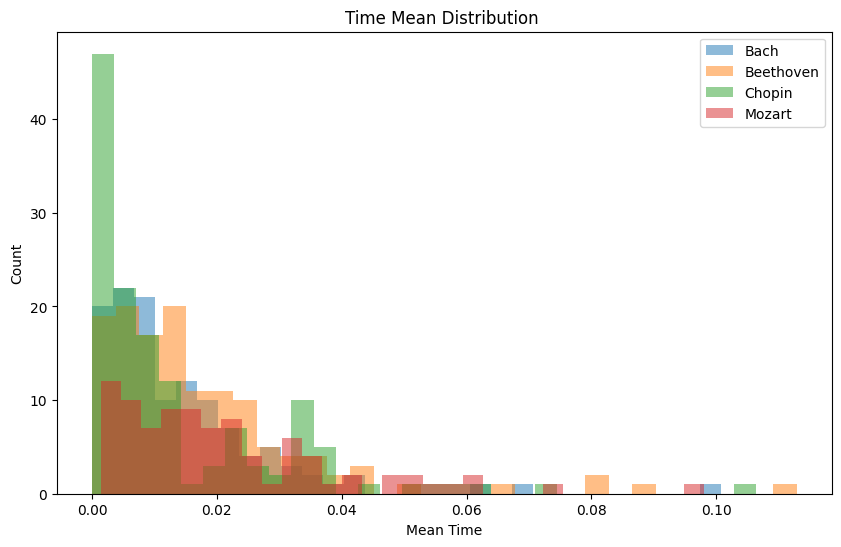

In [50]:
time_vals = time_mean

plt.figure(figsize=(10, 6))
for composer in np.unique(labels):
    comp_time = time_vals[labels == composer]
    plt.hist(comp_time, bins=30, alpha=0.5, label=composer)

plt.title("Time Mean Distribution ")
plt.xlabel("Mean Time")
plt.ylabel("Count")
plt.legend()
plt.show()

# Chord/Chroma Distributions

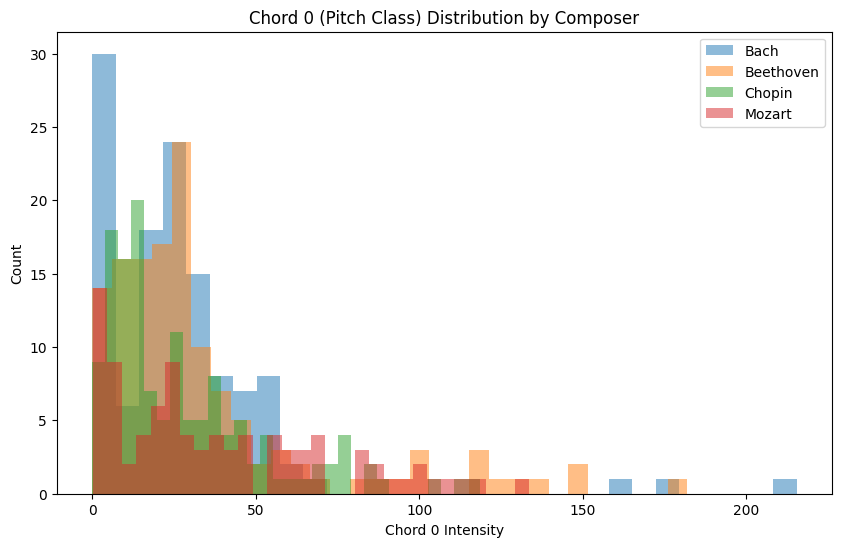

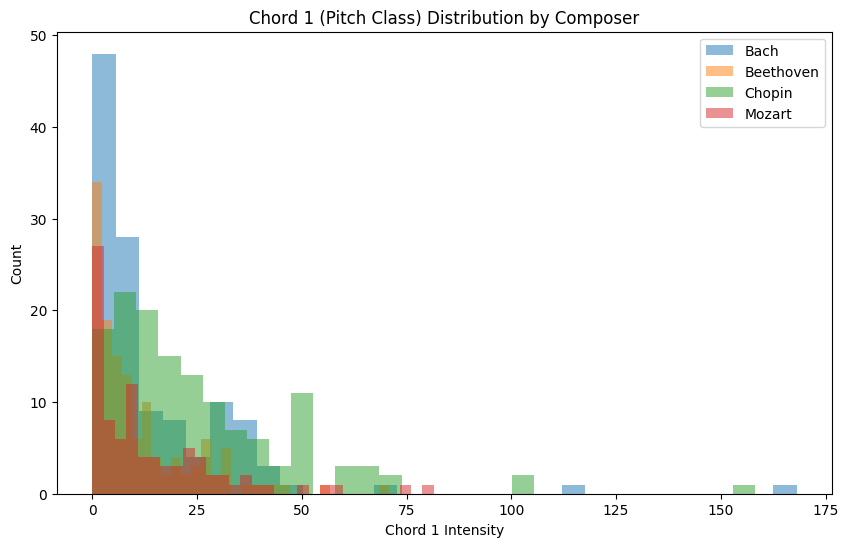

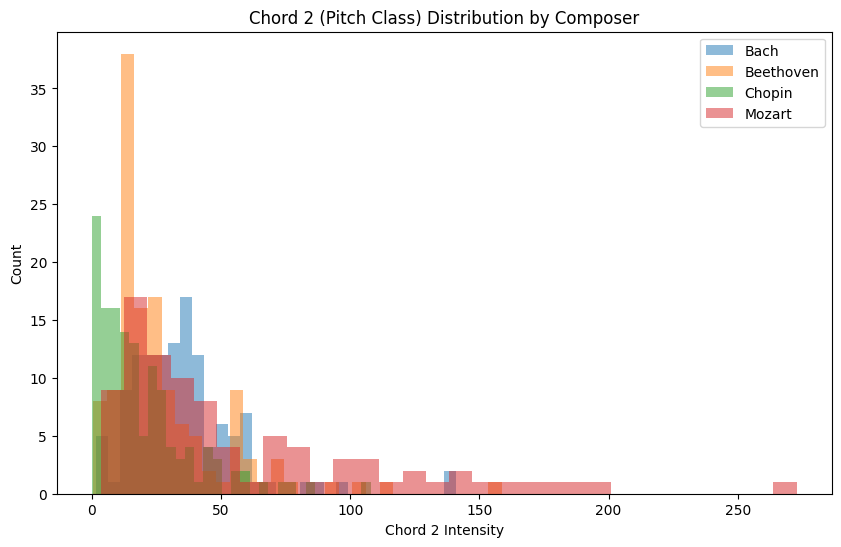

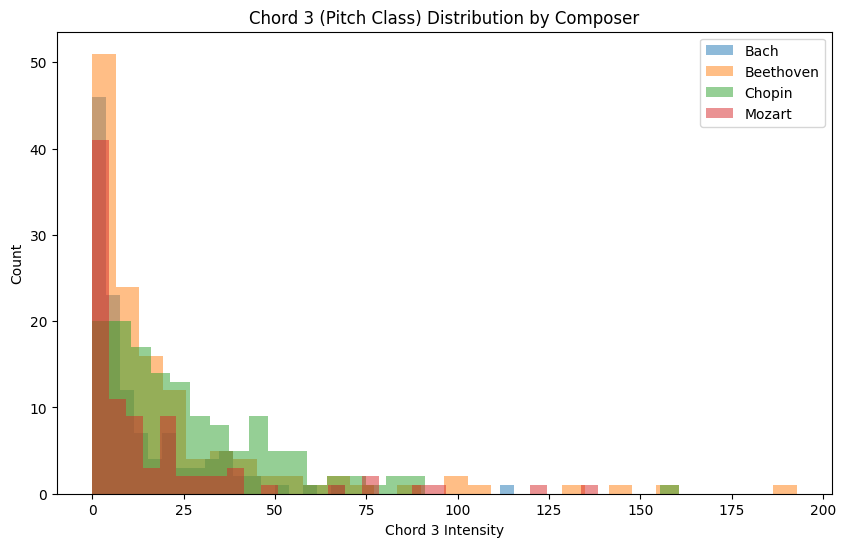

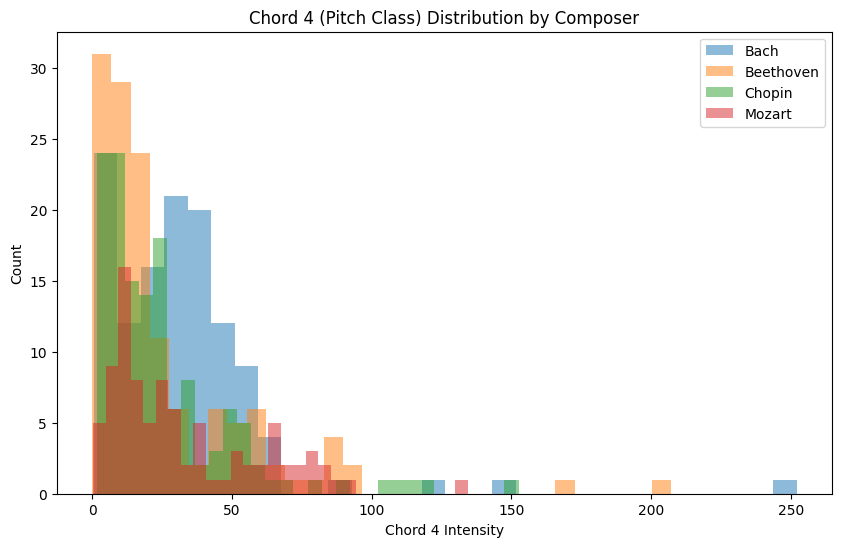

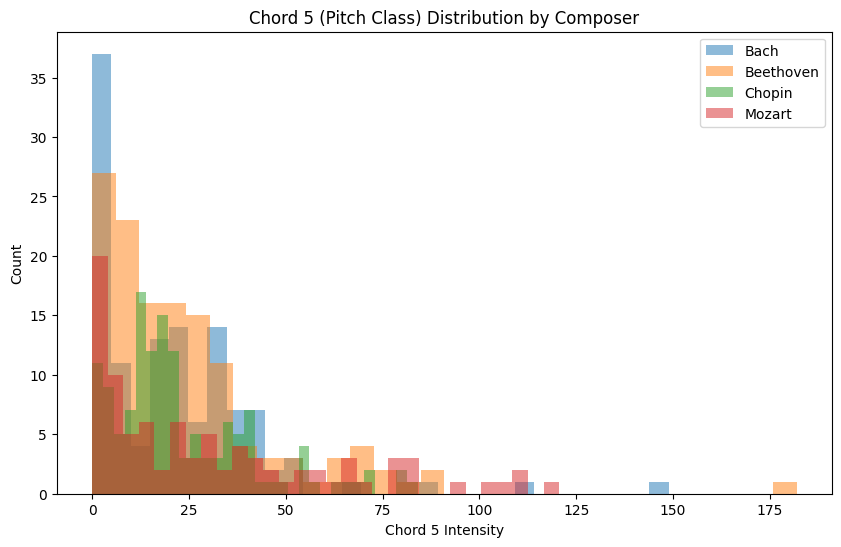

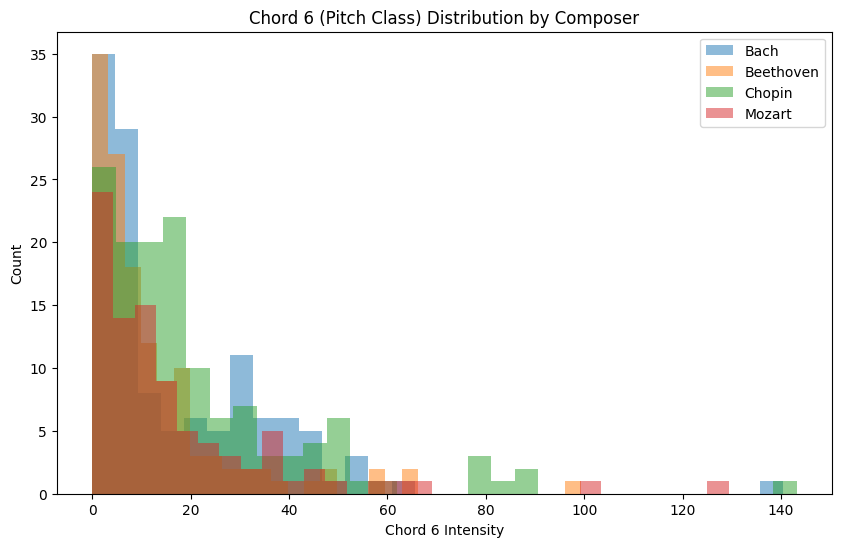

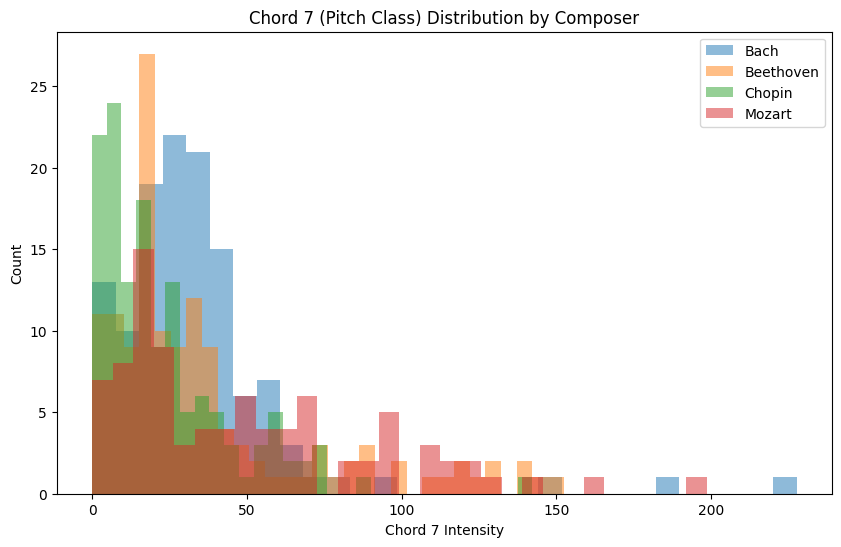

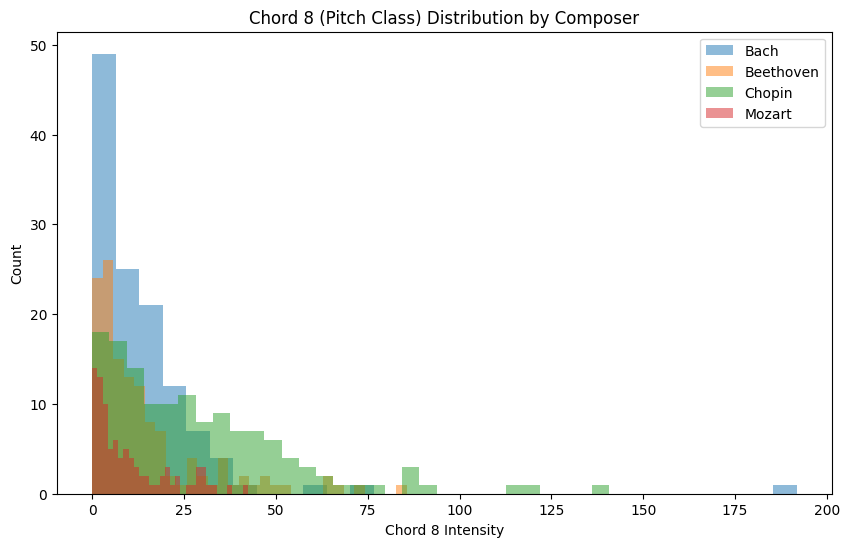

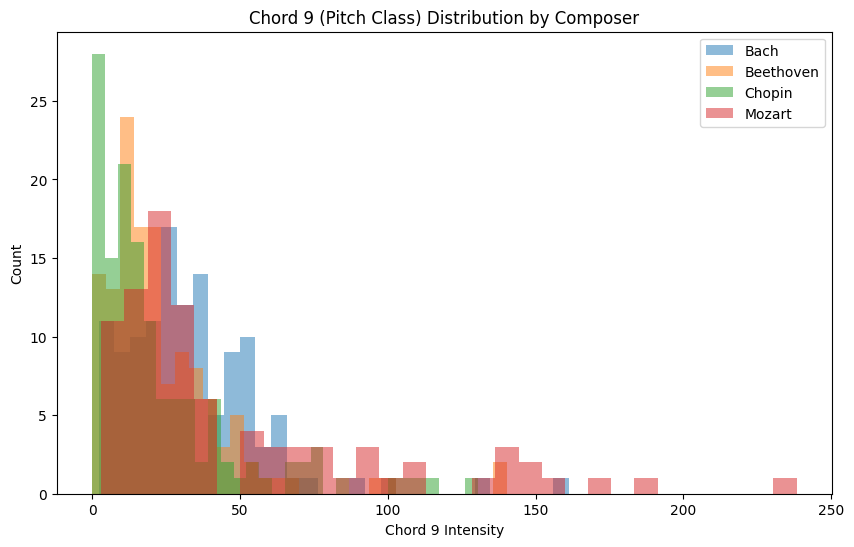

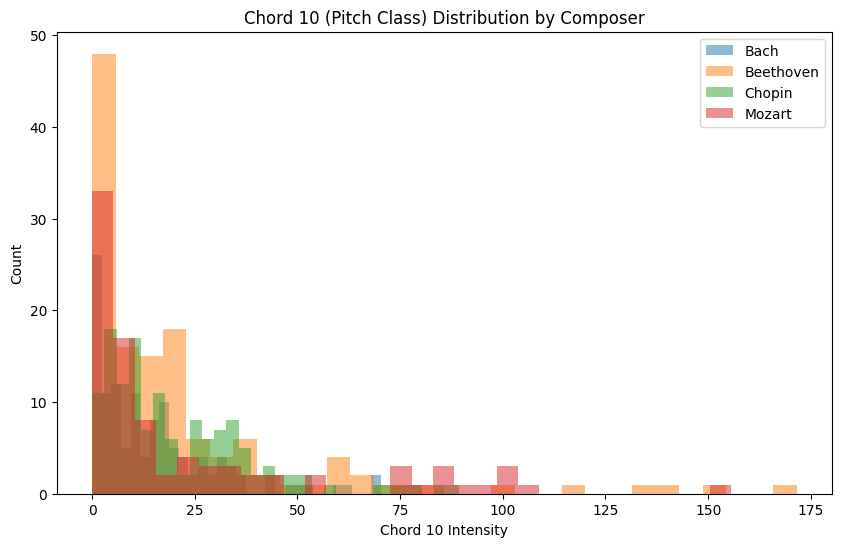

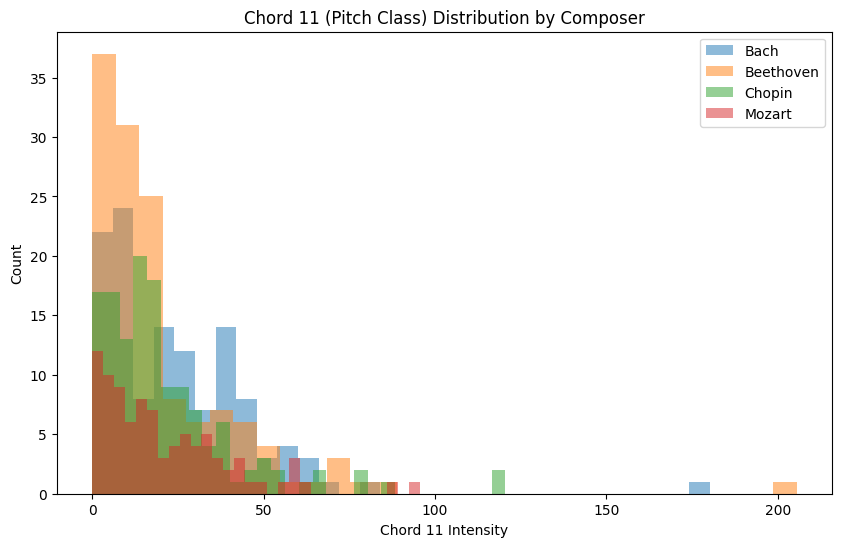

In [48]:
chords = chords_arr

for i in range(chords.shape[1]):
    plt.figure(figsize=(10, 6))
    for composer in np.unique(labels):
        comp_chord = chords[labels == composer, i]
        plt.hist(comp_chord, bins=30, alpha=0.5, label=composer)
    plt.title(f"Chord {i} (Pitch Class) Distribution by Composer")
    plt.xlabel(f"Chord {i} Intensity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()